# Economic Data Analysis with Fred API & Pandas
The FRED® API is a web service that allows developers to write programs and build applications that retrieve economic data from the FRED® and ALFRED® websites hosted by the Economic Research Division of the Federal Reserve Bank of St. Louis.

This notebook was based on a youtube tutorial you can find [here](https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw).

<img src="https://pix4free.org/assets/library/2021-04-28/originals/economic.jpg" width="450" height="300" />


In [1]:
#!pip install fredapi

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

plt.style.use('fivethirtyeight')
pd.set_option("display.max_columns", 500)

color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

fred_key = '52406bf402452956df9cec56e1e370d9'

# 1. Create The Fred Object

In [3]:
fred = Fred(api_key=fred_key)

# 2. Search for economic data!

In [4]:
sp_search = fred.search('S&P', order_by='popularity')

In [5]:
sp_search.head()

id realtime_start realtime_end  \
series id                                                    
BAMLH0A0HYM2      BAMLH0A0HYM2     2023-06-02   2023-06-02   
CSUSHPINSA          CSUSHPINSA     2023-06-02   2023-06-02   
BAMLH0A0HYM2EY  BAMLH0A0HYM2EY     2023-06-02   2023-06-02   
SP500                    SP500     2023-06-02   2023-06-02   
CSUSHPISA            CSUSHPISA     2023-06-02   2023-06-02   

                                                            title  \
series id                                                           
BAMLH0A0HYM2    ICE BofA US High Yield Index Option-Adjusted S...   
CSUSHPINSA        S&P/Case-Shiller U.S. National Home Price Index   
BAMLH0A0HYM2EY       ICE BofA US High Yield Index Effective Yield   
SP500                                                     S&P 500   
CSUSHPISA         S&P/Case-Shiller U.S. National Home Price Index   

               observation_start observation_end     frequency  \
series id                                                        
BAMLH0A0HYM2          1996-12-31      2023-06-01  Daily, Close   
CSUSHPINSA            1987-01-01      2023-03-01       Monthly   
BAMLH0A0HYM2EY        1996-12-31      2023-06-01  Daily, Close   
SP500                 2013-06-03      2023-06-01  Daily, Close   
CSUSHPISA             1987-01-01      2023-03-01       Monthly   

               frequency_short               units         units_short  \
series id                                                                
BAMLH0A0HYM2                 D             Percent                   %   
CSUSHPINSA                   M  Index Jan 2000=100  Index Jan 2000=100   
BAMLH0A0HYM2EY               D             Percent                   %   
SP500                        D               Index               Index   
CSUSHPISA                    M  Index Jan 2000=100  Index Jan 2000=100   

                    seasonal_adjustment seasonal_adjustment_short  \
series id                                                           
BAMLH0A0HYM2    Not Seasonally Adjusted                       NSA   
CSUSHPINSA      Not Seasonally Adjusted                       NSA   
BAMLH0A0HYM2EY  Not Seasonally Adjusted                       NSA   
SP500           Not Seasonally Adjusted                       NSA   
CSUSHPISA           Seasonally Adjusted                        SA   

                             last_updated popularity  \
series id                                              
BAMLH0A0HYM2    2023-06-02 08:19:07-05:00         94   
CSUSHPINSA      2023-05-30 09:01:01-05:00         90   
BAMLH0A0HYM2EY  2023-06-02 08:19:11-05:00         83   
SP500           2023-06-01 19:10:50-05:00         82   
CSUSHPISA       2023-05-30 09:01:04-05:00         81   

                                                            notes  
series id                                                          
BAMLH0A0HYM2    The ICE BofA Option-Adjusted Spreads (OASs) ar...  
CSUSHPINSA      For more information regarding the index, plea...  
BAMLH0A0HYM2EY  This data represents the effective yield of th...  
SP500           The observations for the S&P 500 represent the...  
CSUSHPISA       For more information regarding the index, plea...

# 3. Pull Raw Data & Plot

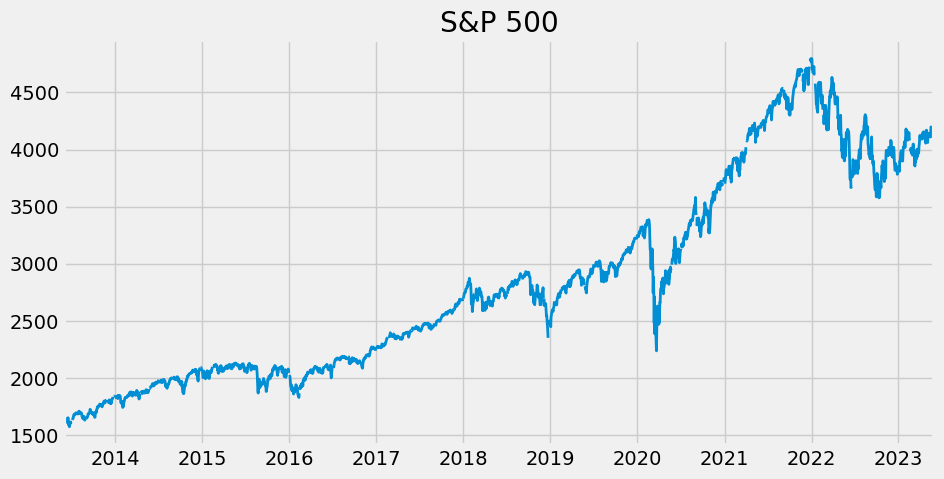

In [6]:
sp500 = fred.get_series(series_id='SP500')
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)
plt.show()

# 4. Pull and Join Multiple Data Series

In [7]:
unemp_df = fred.search('unemployment rate', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [8]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Slow request to avoid block
unemp_results = pd.concat(all_results, axis=1)

In [9]:
cols_to_drop = []
for i in unemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
unemp_results = unemp_results.drop(columns = cols_to_drop, axis=1)

In [10]:
unemp_states = unemp_results.copy()  #.drop('UNRATE', axis=1)
unemp_states = unemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
unemp_states.columns = [id_to_state[c] for c in unemp_states.columns]

In [11]:
#!pip install ipykernel
#!pip install --upgrade nbformat

In [12]:
# Plot States Unemployment Rate
px.line(unemp_states)

# Pull February 2023 Unemployment Rate Per State

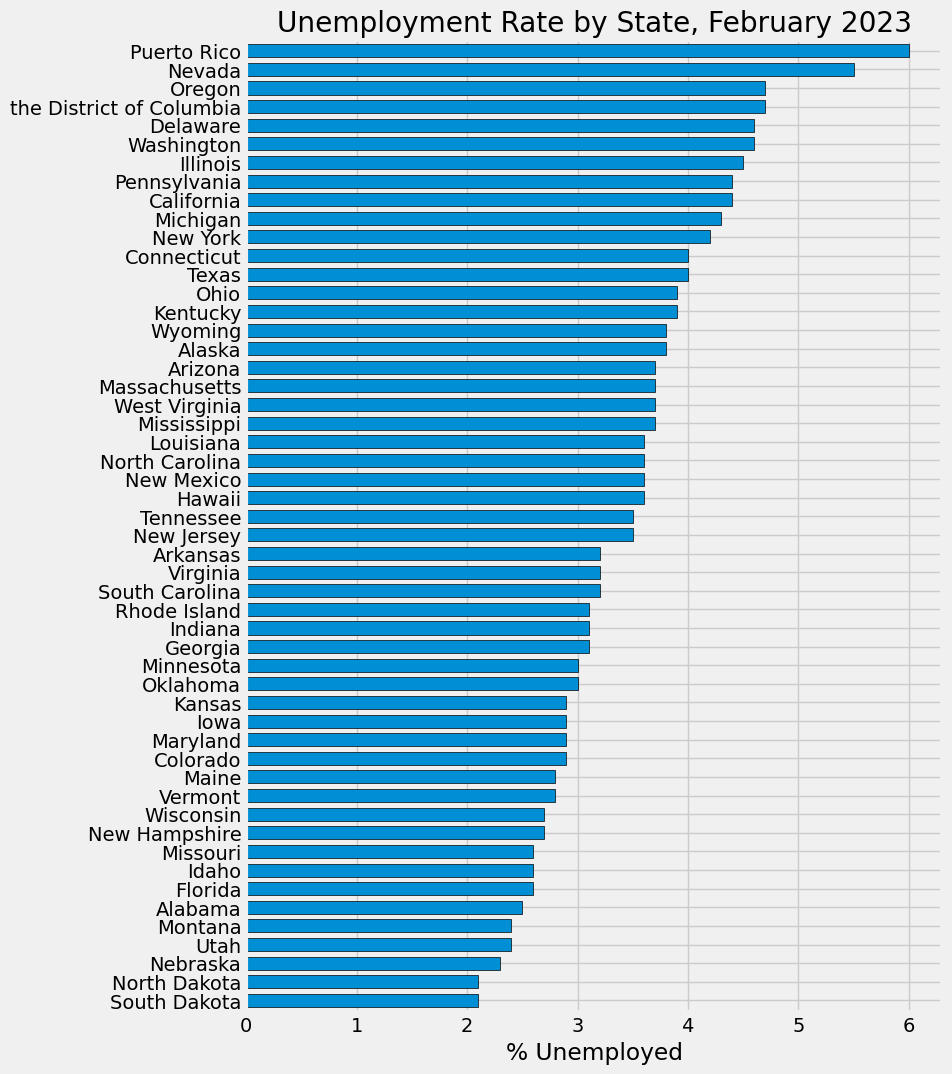

In [13]:
ax = unemp_states.loc[unemp_states.index == '2023-02-01'].T \
    .sort_values('2023-02-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, February 2023')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

# Pull Participation Rate

In [14]:
part_df = fred.search('participation rate', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [15]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Slow request to avoid block
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

# Plot Unemployment vs Participation for each state!

In [16]:
# Fix DC
unemp_states = unemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

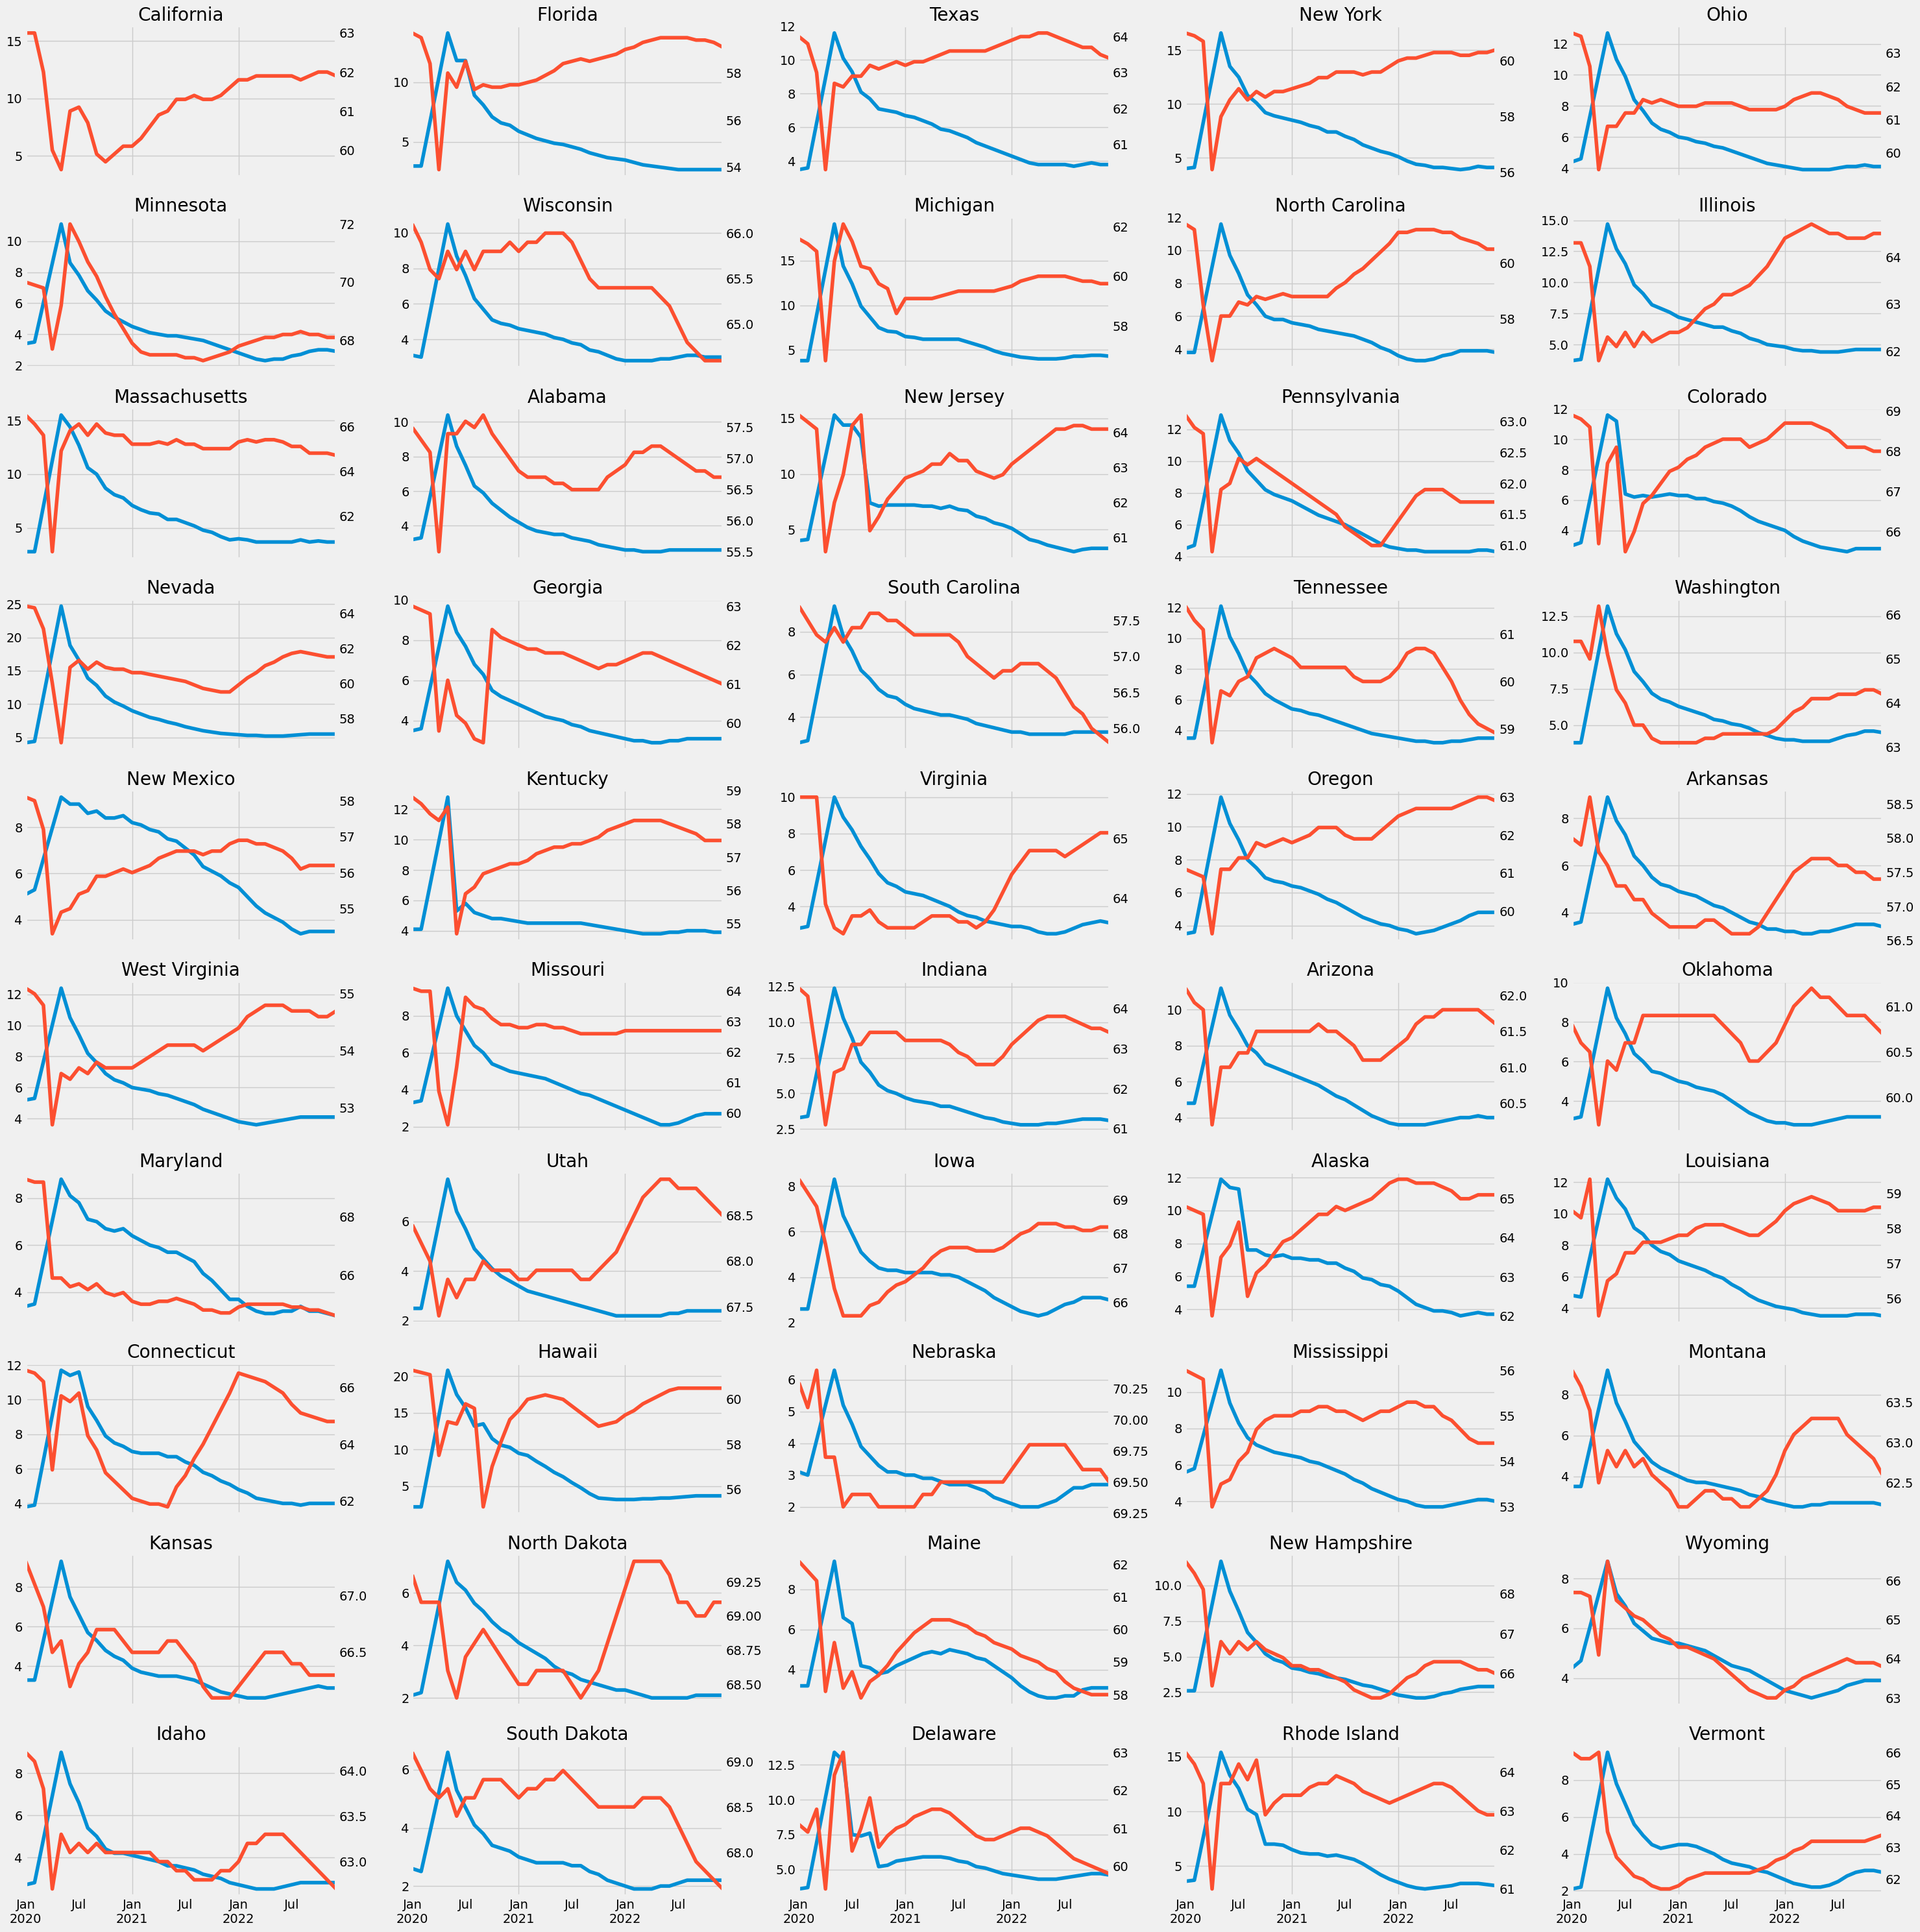

In [17]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in unemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    unemp_states.query('index >= 2020 and index < 2023')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2023')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()

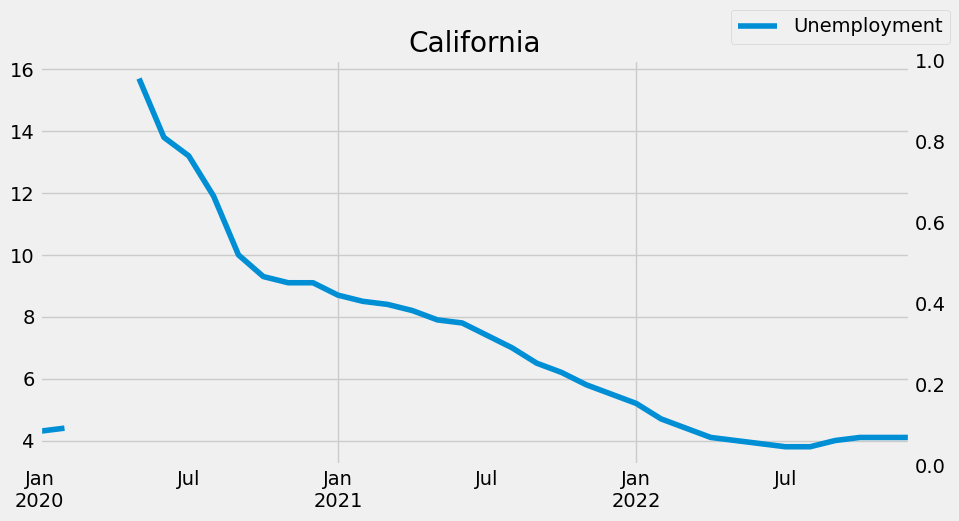

In [23]:
state = 'California'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
unemp_states2 = unemp_states.asfreq('MS')
l1 = unemp_states2.query('index >= 2020 and index < 2023')[state] \
    .plot(ax=ax, label='Unemployment')
#l2 = part_states.dropna().query('index >= 2021 and index < 2022')[state] \
#    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment','Participation'])
plt.show()